# NPPC historical phenotypic wheat data analysis

## Load packages, custom functions and data

In [1]:
library(readxl)
library(tidyverse)
library(multtest)
library(asreml)

source("../custom_functions.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
  

Online License checked out Tue Apr 30 21:03:35 2024


Loading ASReml-R version 4.2




In [2]:
data_total_winter <- preprocess("Historic_Wheat_W_NPPC.xlsx")
write_csv(data_total_winter, "NPPC_winter_wheat.csv")
genotypes_w <- distinct(data_total_winter["accenumb"]) |> rename("genotype" = "accenumb")
cat("Winter Wheat:\n", nrow(data_total_winter), "observations\n", nrow(genotypes_w), "genotypes\n", nrow(distinct(data_total_winter["campaign"])), "campaigns\n\n")
summary(data_total_winter[c("days_to_heading", "plant_height", "thousand_kernel_weight")])

Winter Wheat:
 6180 observations
 4893 genotypes
 40 campaigns



 days_to_heading  plant_height    thousand_kernel_weight
 Min.   : 63.0   Min.   :  9.50   Min.   :10.90         
 1st Qu.:216.0   1st Qu.: 81.00   1st Qu.:38.10         
 Median :222.0   Median : 92.00   Median :42.15         
 Mean   :221.9   Mean   : 94.63   Mean   :42.35         
 3rd Qu.:229.0   3rd Qu.:106.67   3rd Qu.:46.50         
 Max.   :299.0   Max.   :198.33   Max.   :87.95         
 NA's   :608     NA's   :179      NA's   :1793          

In [3]:
data_total_spring <- preprocess("Historic_Wheat_S_NPPC.xlsx")
write_csv(data_total_spring, "NPPC_spring_wheat.csv")
genotypes_s <- distinct(data_total_spring["accenumb"]) |> rename("genotype" = "accenumb")
cat("Spring Wheat:\n", nrow(data_total_spring), "observations\n", nrow(genotypes_s), "genotypes\n", nrow(distinct(data_total_spring["campaign"])), "campaigns\n\n")
summary(data_total_spring[c("days_to_heading", "plant_height", "thousand_kernel_weight")])

Spring Wheat:
 944 observations
 891 genotypes
 31 campaigns



 days_to_heading  plant_height    thousand_kernel_weight
 Min.   : 53.0   Min.   : 35.00   Min.   :21.10         
 1st Qu.: 77.0   1st Qu.: 71.00   1st Qu.:33.50         
 Median :216.0   Median : 88.36   Median :37.80         
 Mean   :162.1   Mean   : 89.62   Mean   :37.98         
 3rd Qu.:238.0   3rd Qu.:107.33   3rd Qu.:41.15         
 Max.   :266.0   Max.   :165.34   Max.   :60.10         
 NA's   :47      NA's   :4        NA's   :380           

## Subset data, remove missing values and singletons, make factors

In [4]:
cat("Winter:\n")
data_sub_WW_HT <- data_total_winter |> make_data_sub("days_to_heading")
data_sub_WW_PH <- data_total_winter |> make_data_sub("plant_height")
data_sub_WW_TKW <- data_total_winter |> make_data_sub("thousand_kernel_weight")

Winter:
1045 days_to_heading rows kept
1887 plant_height rows kept
1682 thousand_kernel_weight rows kept


In [5]:
cat("Spring:\n")
data_sub_SW_HT <- data_total_spring |> make_data_sub("days_to_heading")
data_sub_SW_PH <- data_total_spring |> make_data_sub("plant_height")
data_sub_SW_TKW <- data_total_spring |> make_data_sub("thousand_kernel_weight")

Spring:
14 days_to_heading rows kept
77 plant_height rows kept
42 thousand_kernel_weight rows kept


## Visualise trait values 

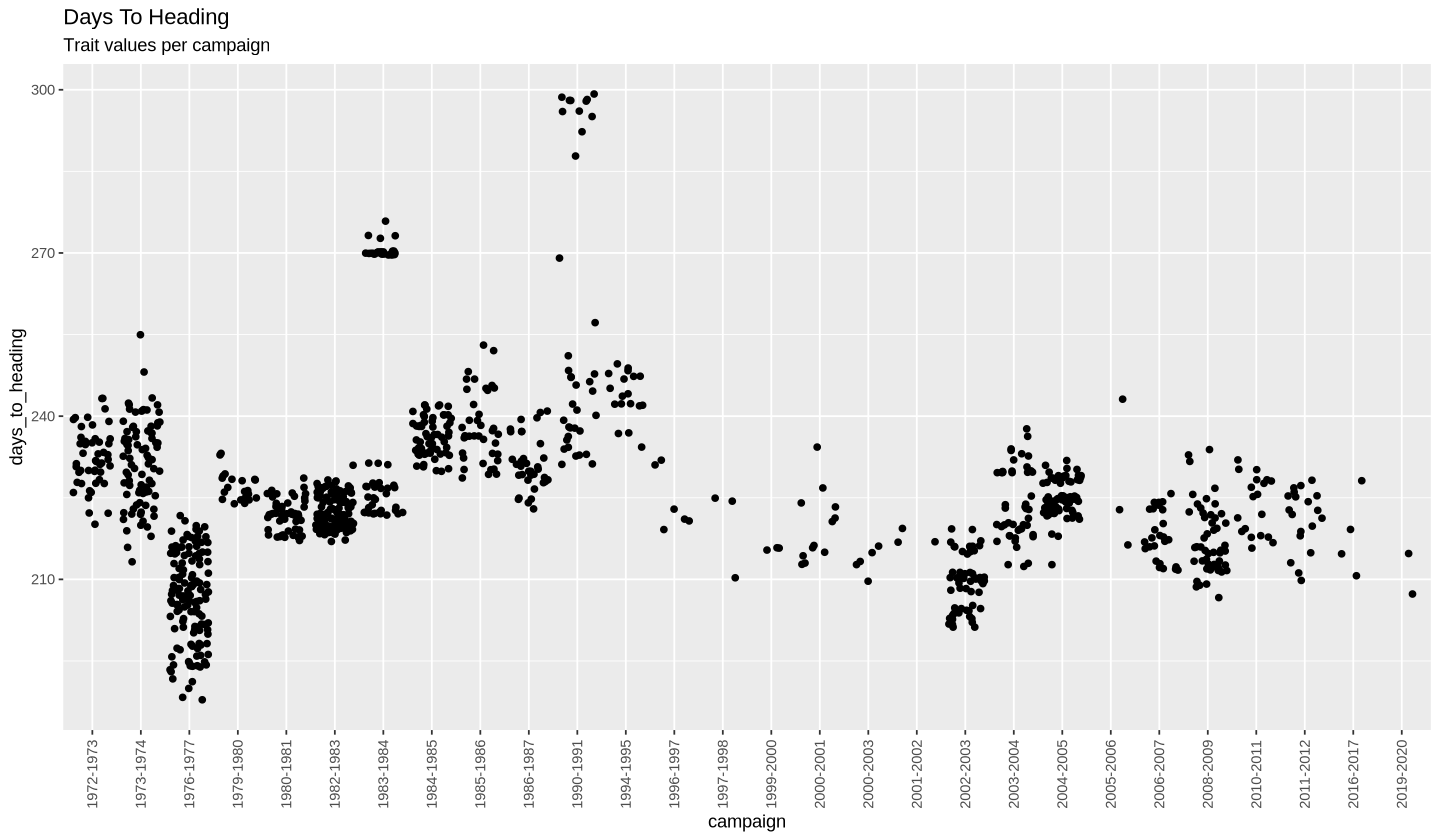

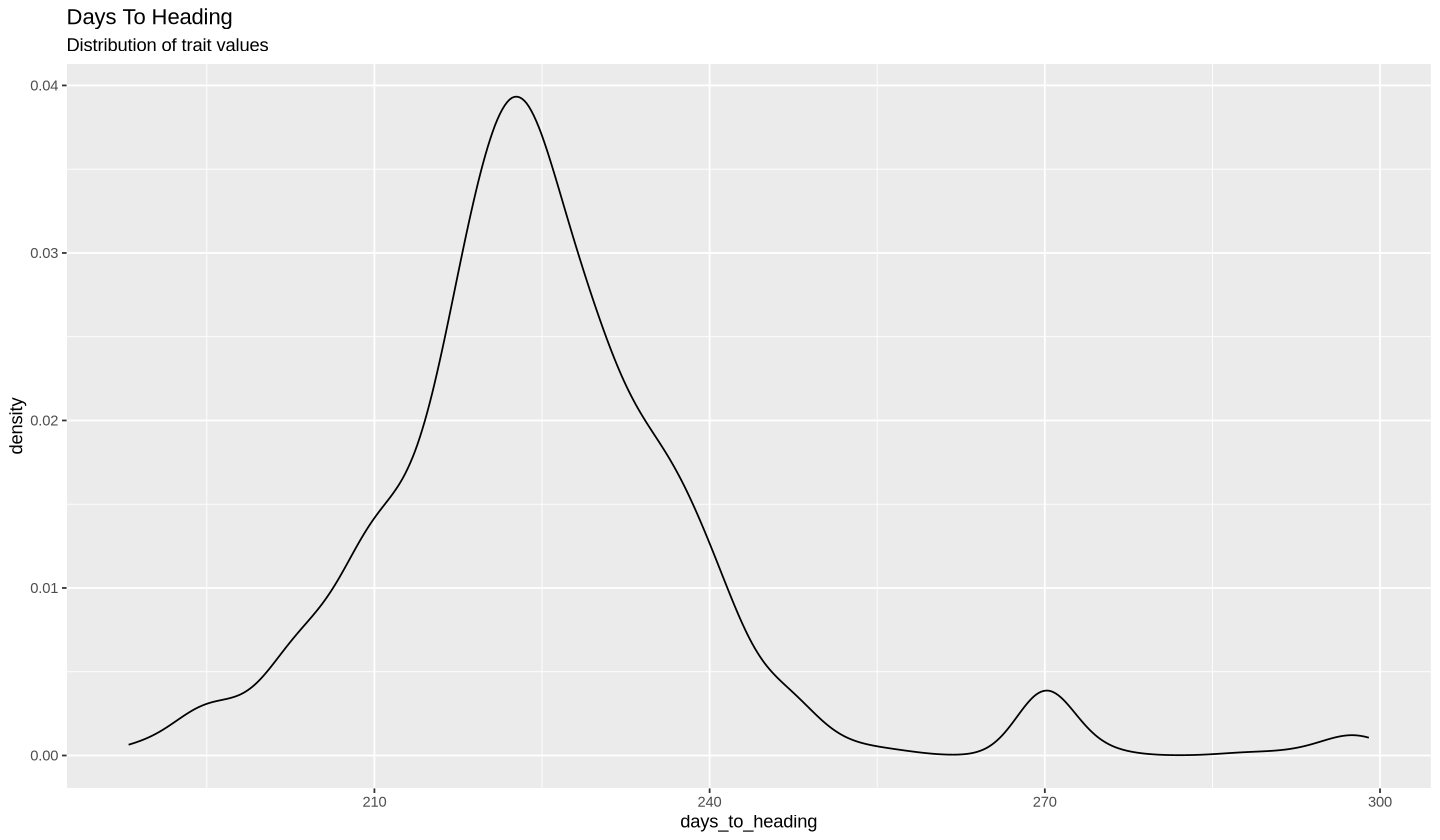

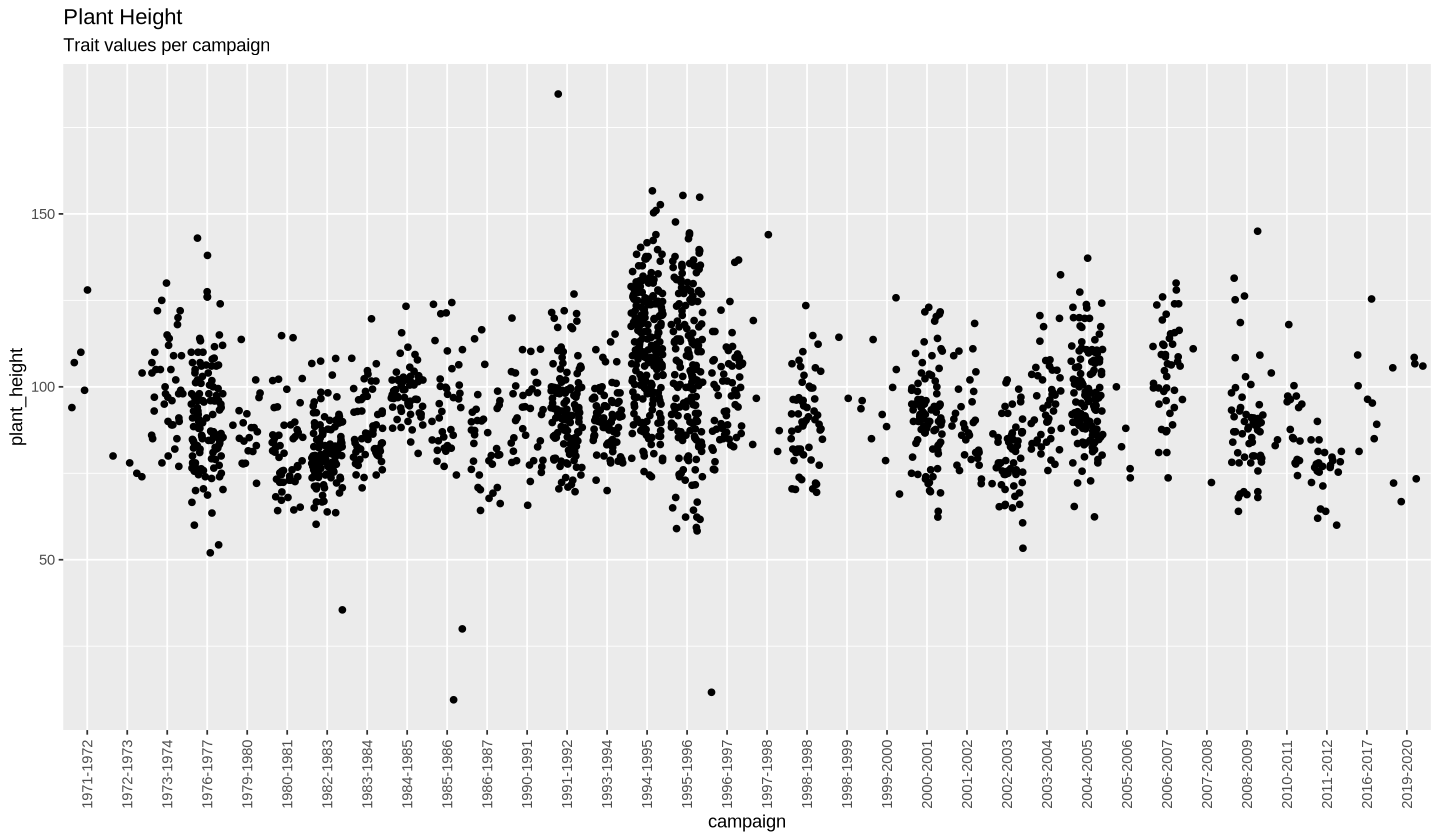

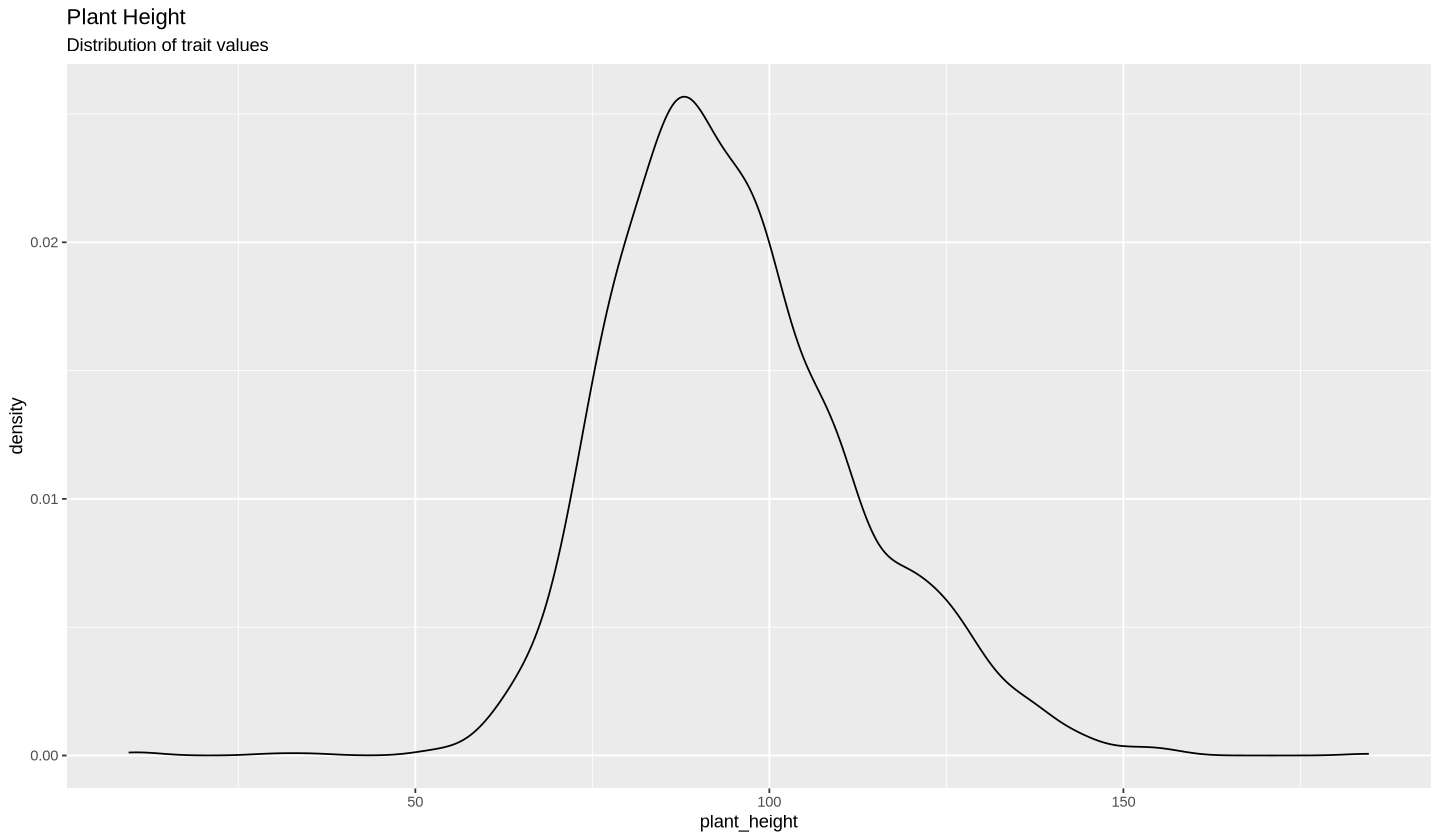

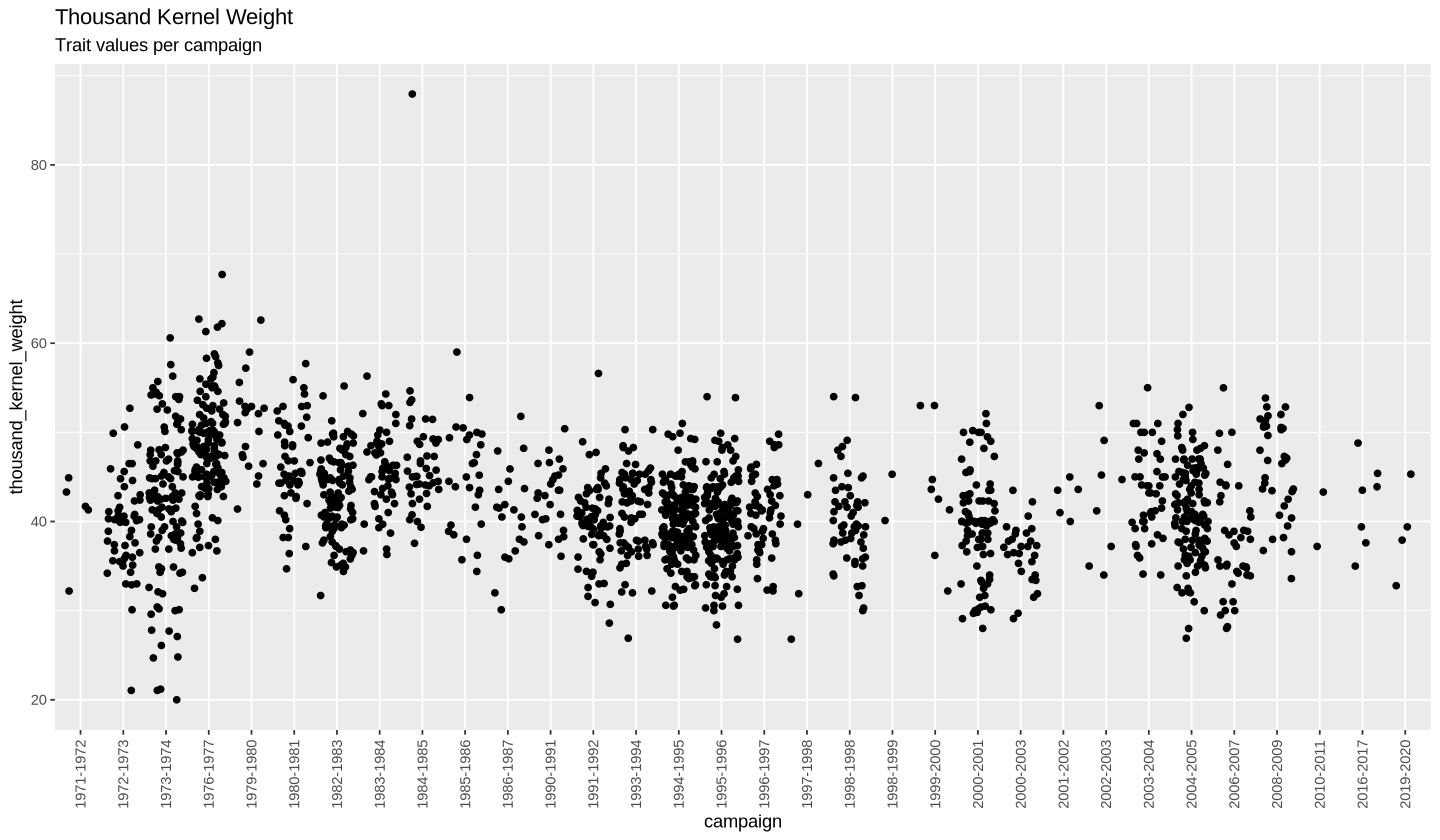

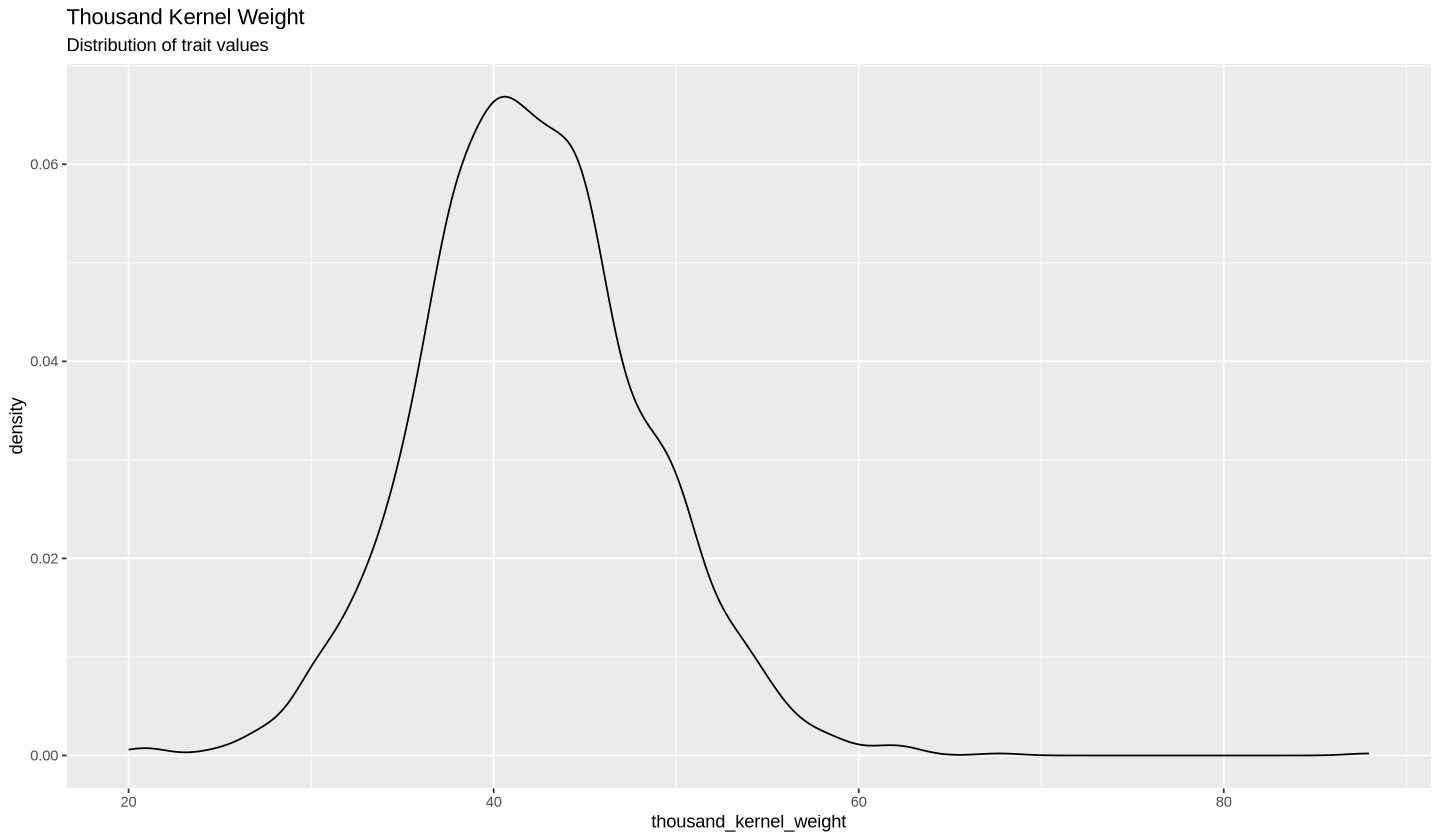

In [6]:
options(repr.plot.width=12, repr.plot.height=7)
data_sub_WW_HT |> visualise_trait(geom_density())
data_sub_WW_PH |> visualise_trait(geom_density())
data_sub_WW_TKW |> visualise_trait(geom_density())

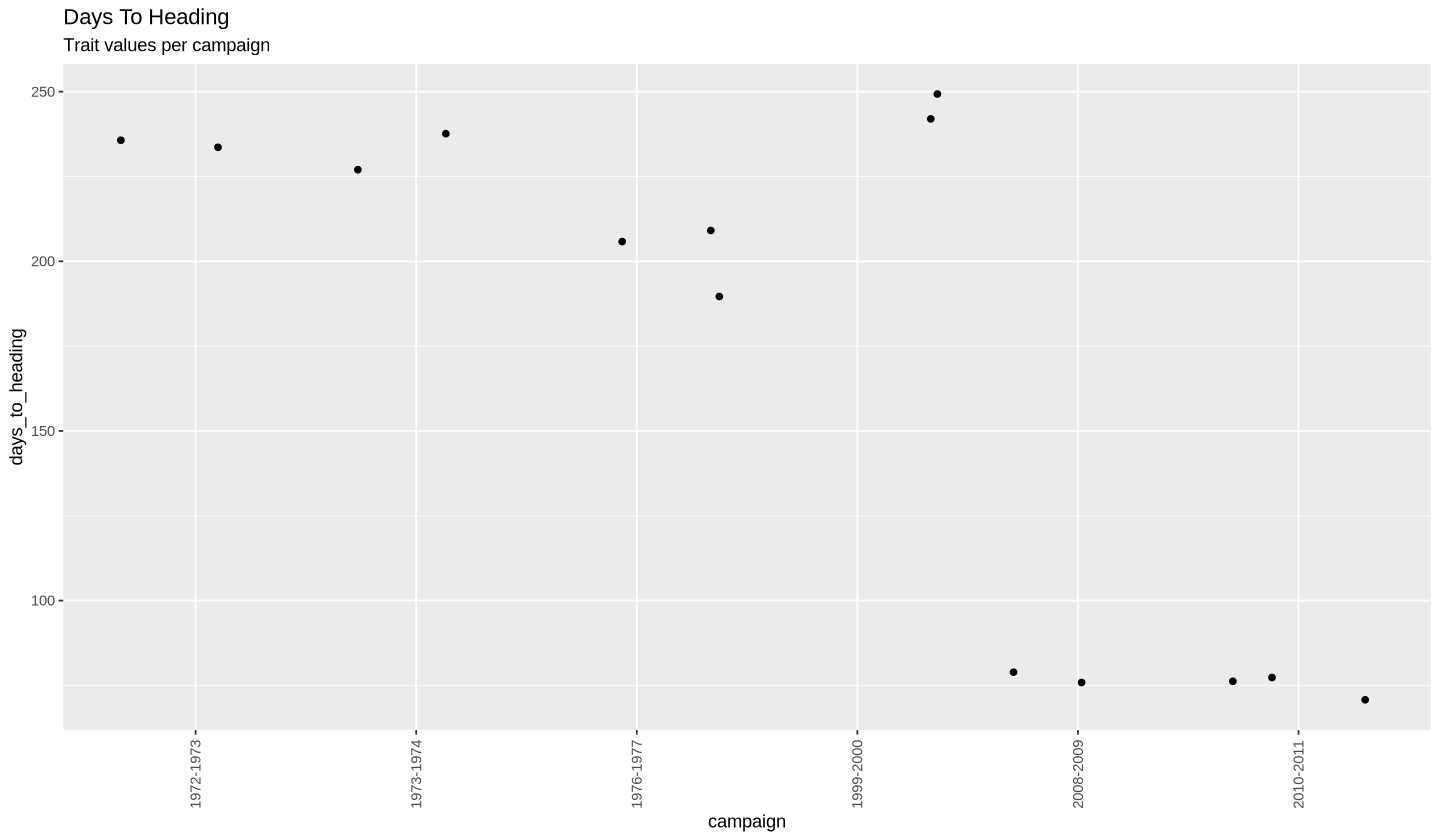

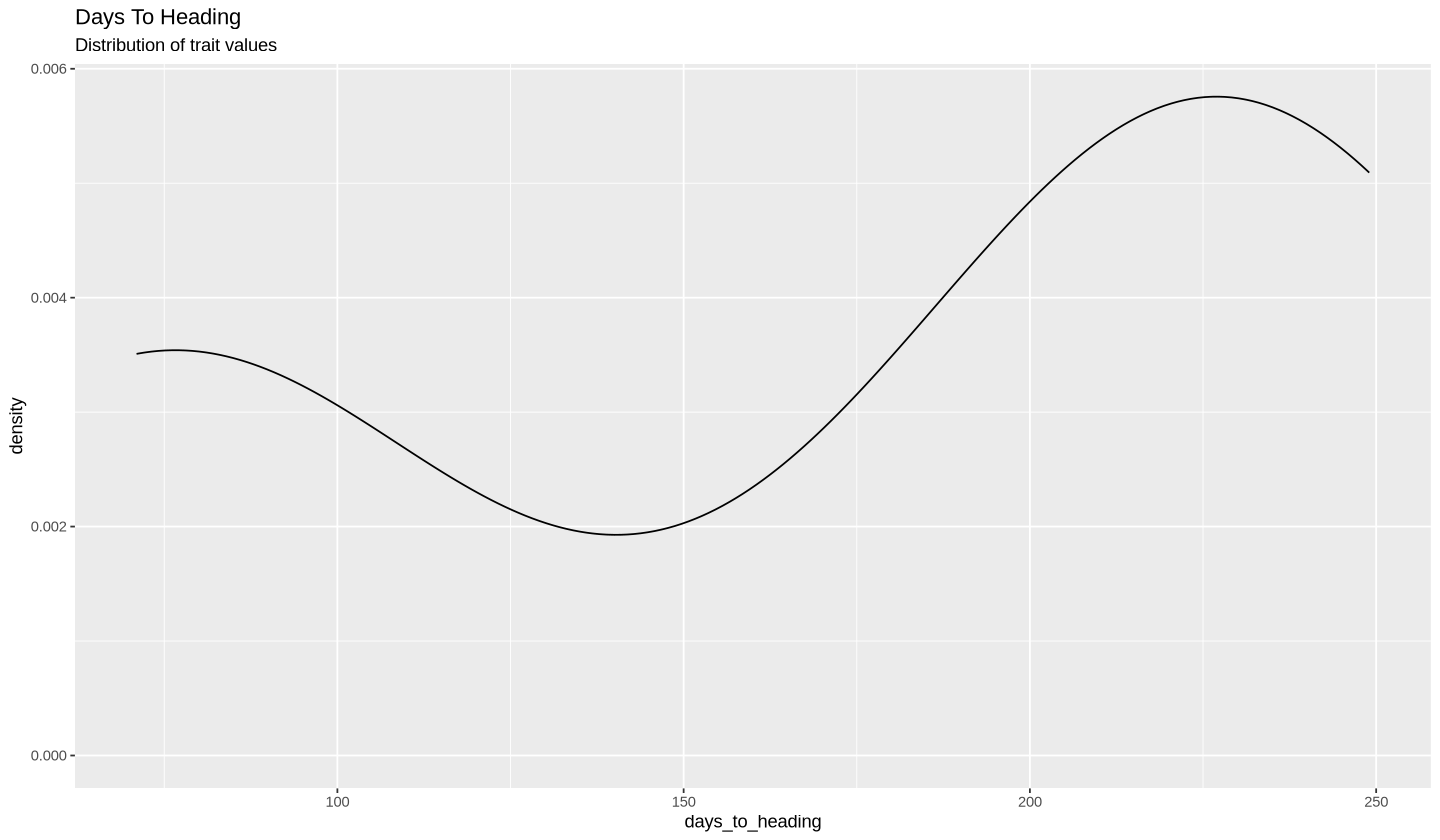

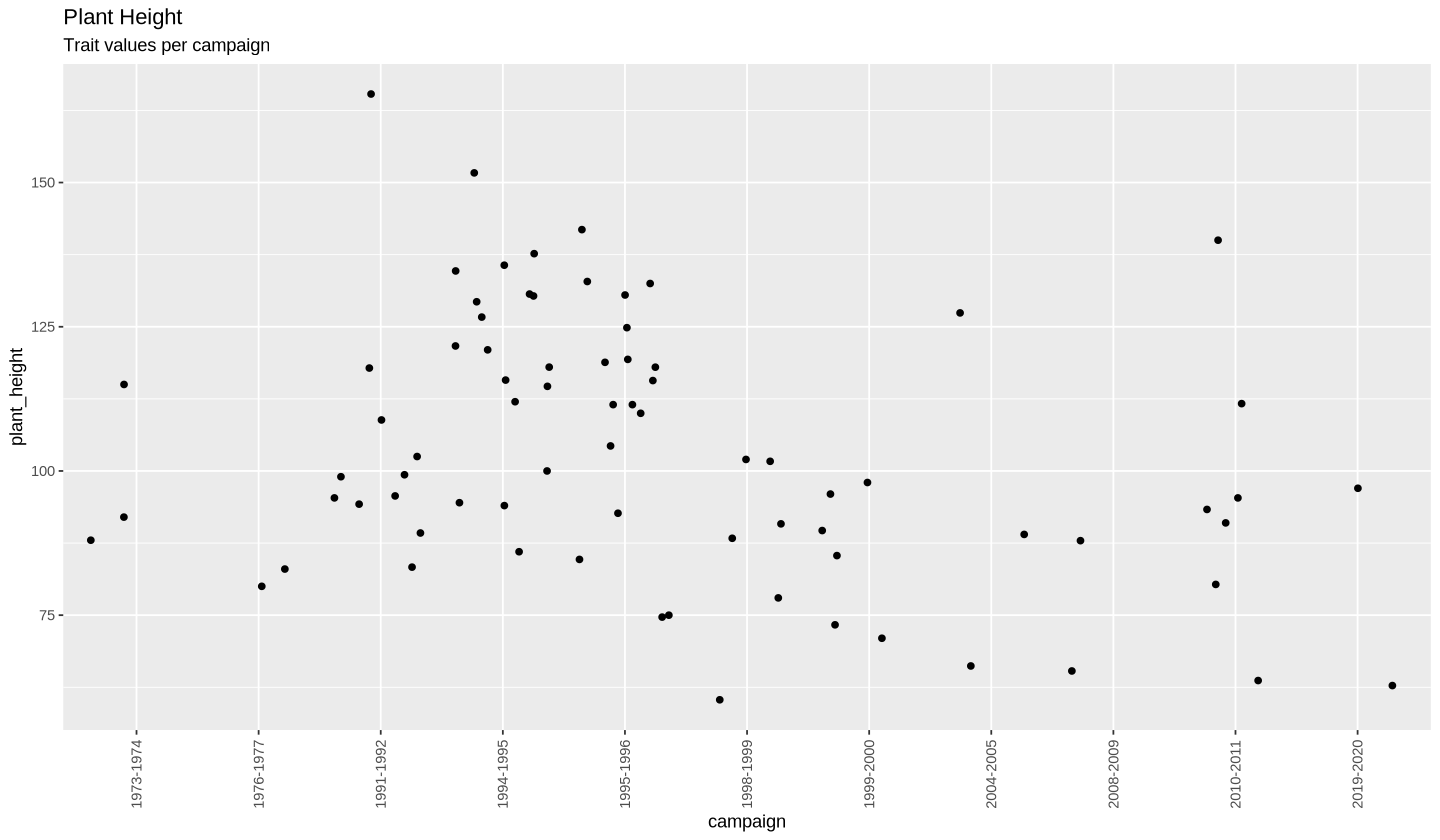

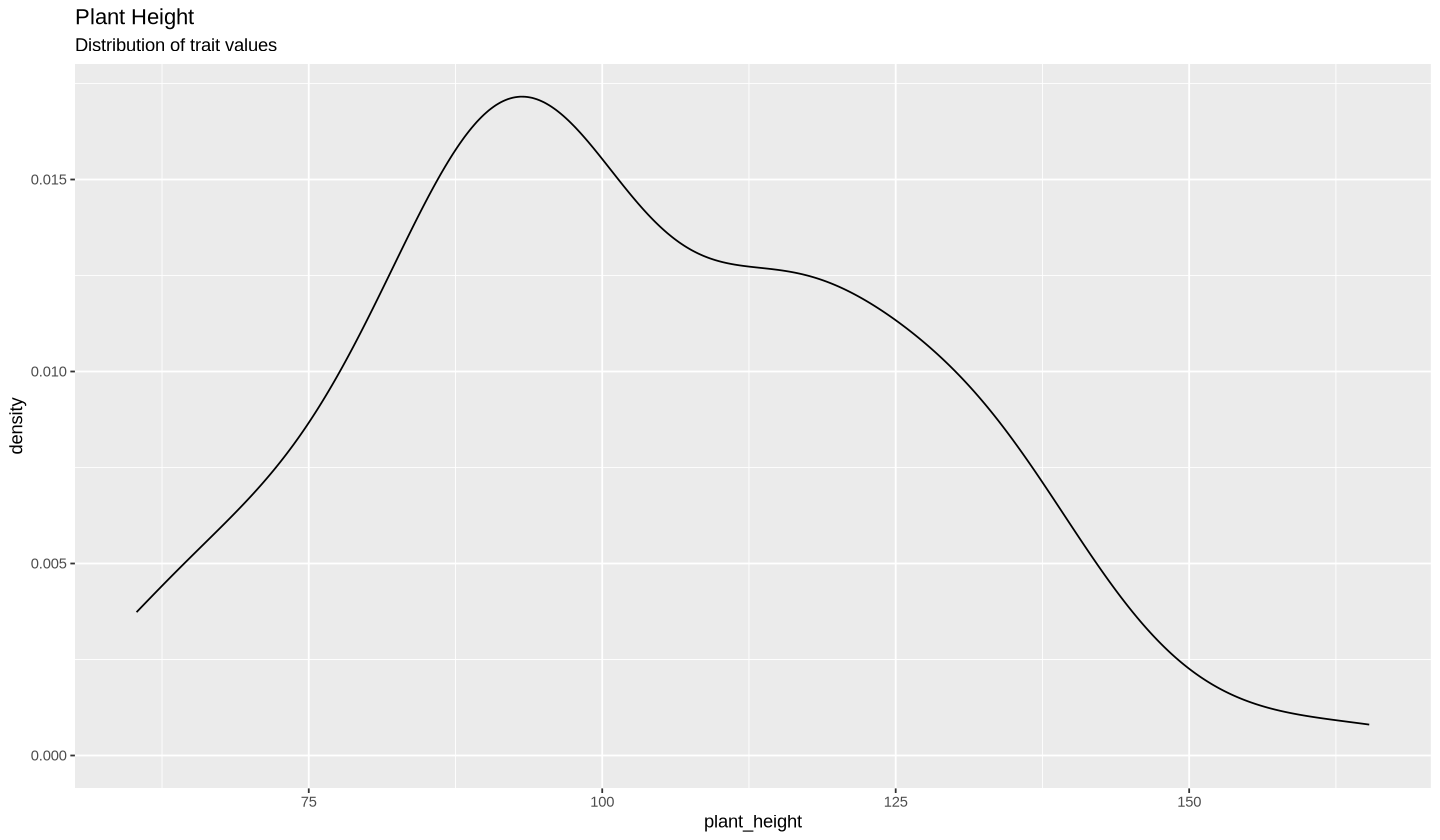

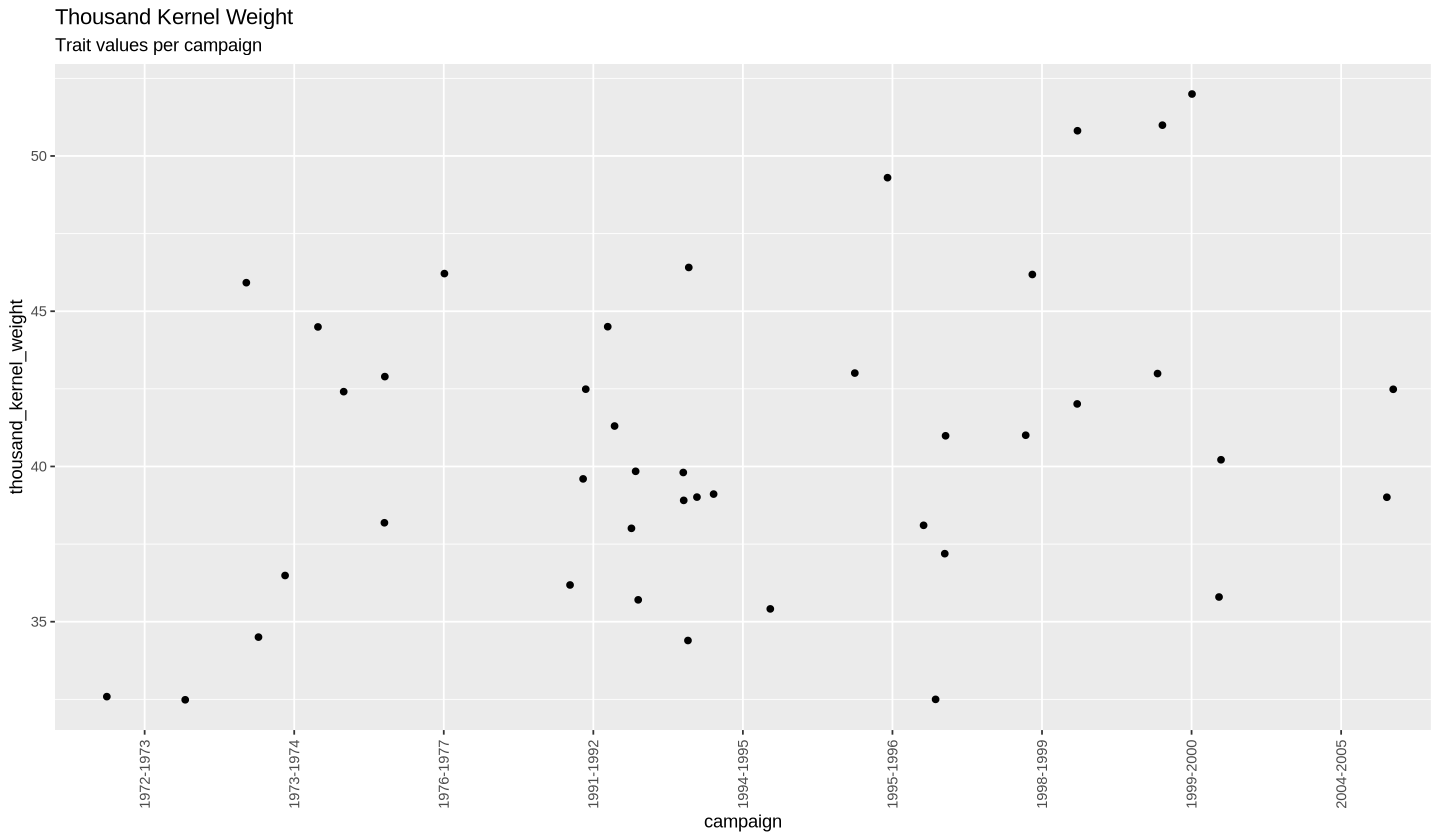

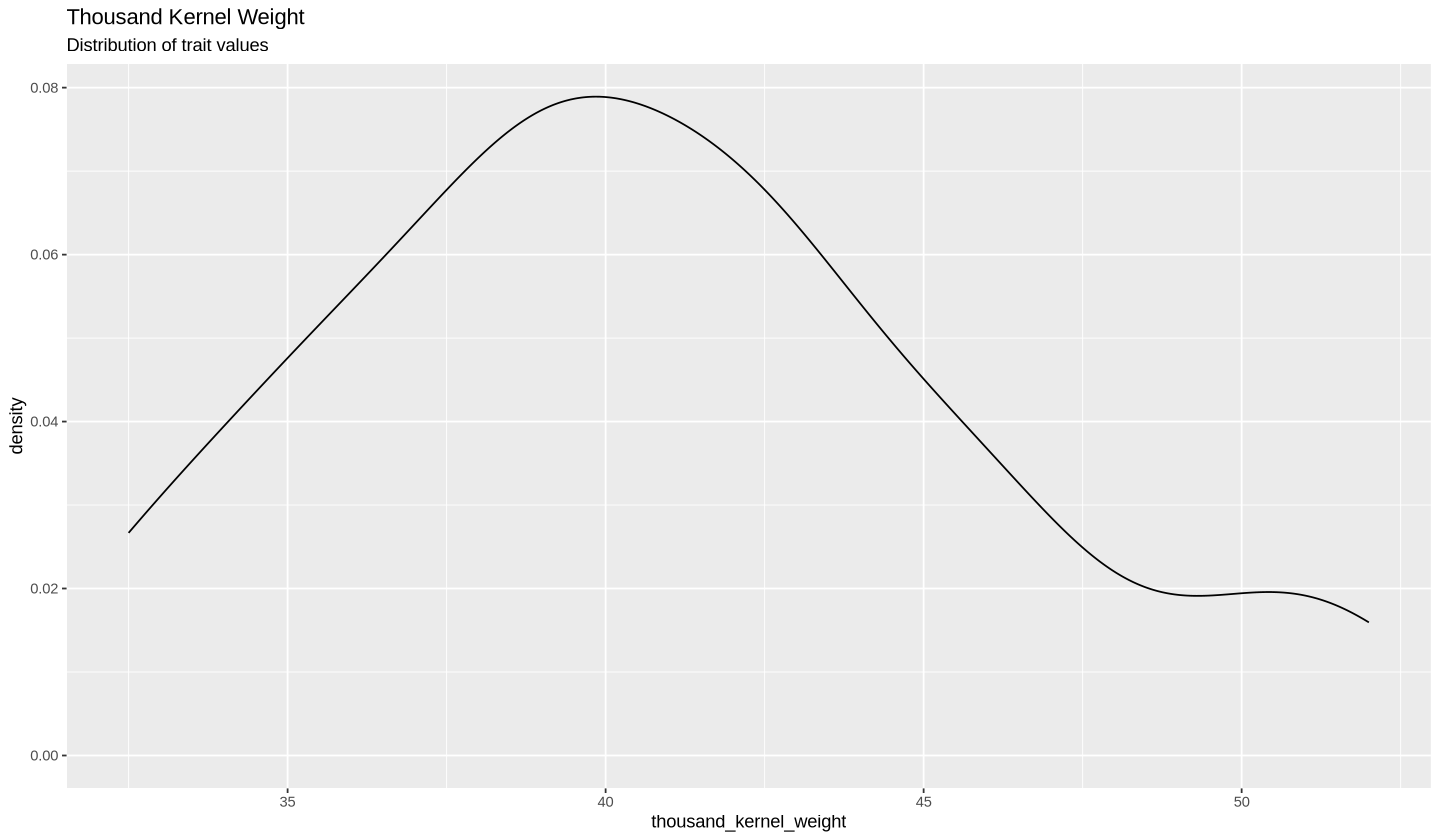

In [7]:
data_sub_SW_HT |> visualise_trait(geom_density())
data_sub_SW_PH |> visualise_trait(geom_density())
data_sub_SW_TKW |> visualise_trait(geom_density())

## Extract and format the campaign effects

In [8]:
asreml_campaign_WW_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_WW_HT)

In [9]:
asreml_campaign_WW_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_WW_PH)

Warning message in asreml(fixed = plant_height ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", :
“Log-likelihood not converged”
Warning message in asreml(fixed = plant_height ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [10]:
asreml_campaign_WW_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_WW_TKW)

In [11]:
# asreml_campaign_SW_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
#                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
#                              data = data_sub_SW_HT)
# # Error: The estimation was aborted; too many exceptions.

In [12]:
asreml_campaign_SW_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_SW_PH)

In [13]:
asreml_campaign_SW_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_SW_TKW)

Warning message in asreml(fixed = thousand_kernel_weight ~ campaign, random = ~accenumb, :
“Some components changed by more than 1% on the last iteration”


In [14]:
campaign_effect_WW_HT <- get_campaign_effect(asreml_campaign_WW_HT)
campaign_effect_WW_PH <- get_campaign_effect(asreml_campaign_WW_PH)
campaign_effect_WW_TKW <- get_campaign_effect(asreml_campaign_WW_TKW)

In [15]:
#campaign_effect_SW_HT <- get_campaign_effect(asreml_campaign_SW_HT)
campaign_effect_SW_PH <- get_campaign_effect(asreml_campaign_SW_PH)
campaign_effect_SW_TKW <- get_campaign_effect(asreml_campaign_SW_TKW)

## Extract heterogeneous error variances

In [16]:
error_var_WW_HT <- get_error_var(asreml_campaign_WW_HT)
error_var_WW_PH <- get_error_var(asreml_campaign_WW_PH)
error_var_WW_TKW <- get_error_var(asreml_campaign_WW_TKW)

In [17]:
#error_var_SW_HT <- get_error_var(asreml_campaign_SW_HT)
error_var_SW_PH <- get_error_var(asreml_campaign_SW_PH)
error_var_SW_TKW <- get_error_var(asreml_campaign_SW_TKW)

## Calculate and standardize the coefficient of variation (CV)

In [18]:
CV_df_WW_HT <- make_CV_df(campaign_effect_WW_HT, error_var_WW_HT)
CV_df_WW_PH <- make_CV_df(campaign_effect_WW_PH, error_var_WW_PH)
CV_df_WW_TKW <- make_CV_df(campaign_effect_WW_TKW, error_var_WW_TKW)

In [19]:
#CV_df_SW_HT <- make_CV_df(campaign_effect_SW_HT, error_var_SW_HT)
CV_df_SW_PH <- make_CV_df(campaign_effect_SW_PH, error_var_SW_PH)
CV_df_SW_TKW <- make_CV_df(campaign_effect_SW_TKW, error_var_SW_TKW)

## Remove outlier campaigns

In [20]:
data_corrected_WW_HT_I <- data_sub_WW_HT |> correct_I(CV_df_WW_HT)
data_corrected_WW_PH_I <- data_sub_WW_PH |> correct_I(CV_df_WW_PH)
data_corrected_WW_TKW_I <- data_sub_WW_TKW |> correct_I(CV_df_WW_TKW)

1 outlier campaign(s) detected for trait days_to_heading: 1990-1991 
1 outlier campaign(s) detected for trait plant_height: 2007-2008 
0 outlier campaign(s) detected for trait thousand_kernel_weight


In [21]:
#data_corrected_SW_HT_I <- data_sub_SW_HT |> correct_I(CV_df_SW_HT)
data_corrected_SW_PH_I <- data_sub_SW_PH |> correct_I(CV_df_SW_PH)
data_corrected_SW_TKW_I <- data_sub_SW_TKW |> correct_I(CV_df_SW_TKW)

0 outlier campaign(s) detected for trait plant_height
0 outlier campaign(s) detected for trait thousand_kernel_weight


## Residuals

In [22]:
asreml_res_WW_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_WW_HT_I)

In [23]:
asreml_res_WW_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_WW_PH_I)

In [24]:
asreml_res_WW_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_WW_TKW_I)

In [25]:
# asreml_res_SW_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
#                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
#                  data = data_corrected_SW_HT_I)

In [26]:
asreml_res_SW_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_SW_PH_I)

Warning message in asreml(fixed = plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [27]:
asreml_res_SW_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_SW_TKW_I)

Warning message in asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Log-likelihood not converged”
Warning message in asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration”


118 outlier value(s) detected for trait Days To Heading 
74 outlier value(s) detected for trait Plant Height 


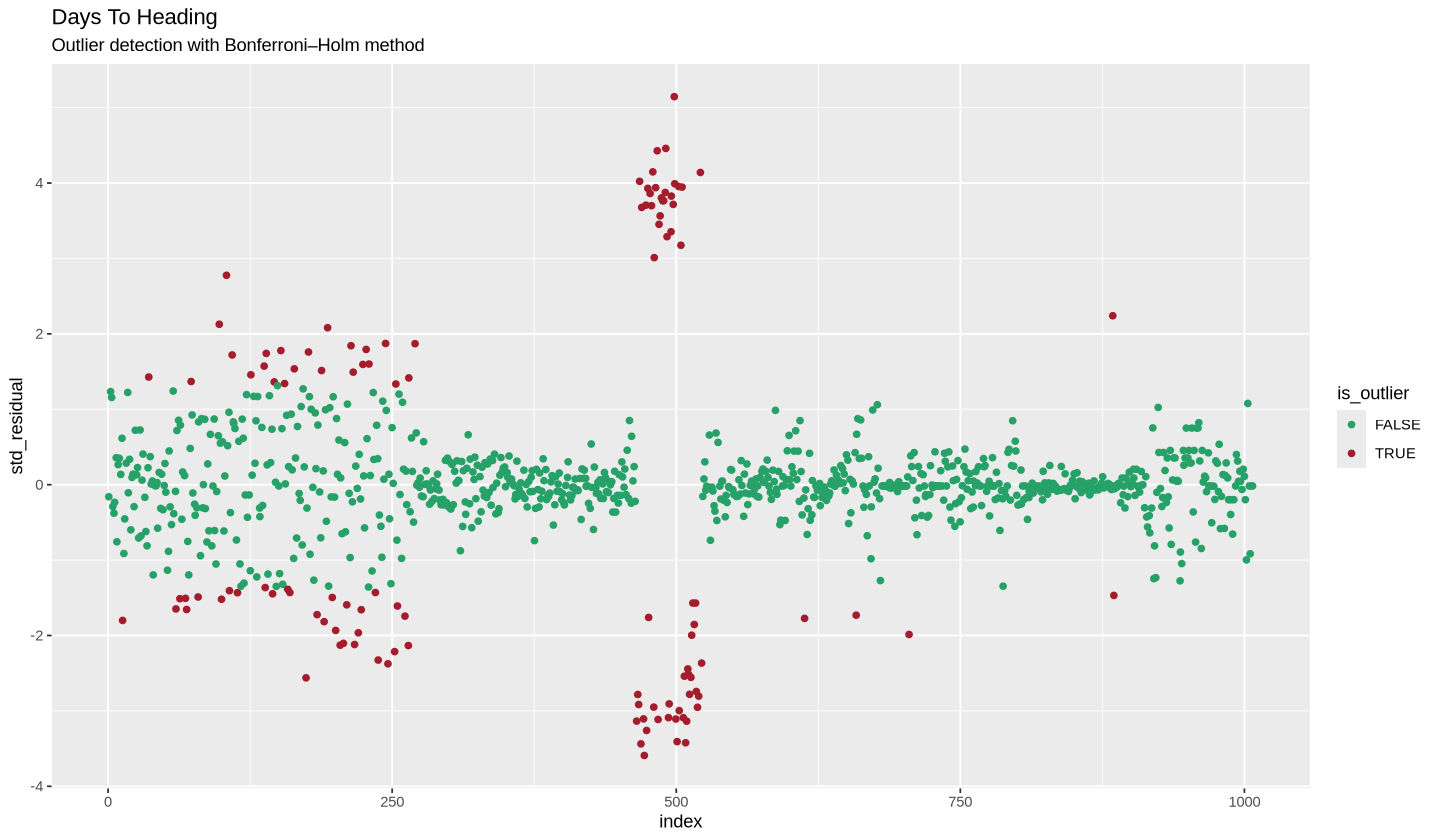

248 outlier value(s) detected for trait Thousand Kernel Weight 


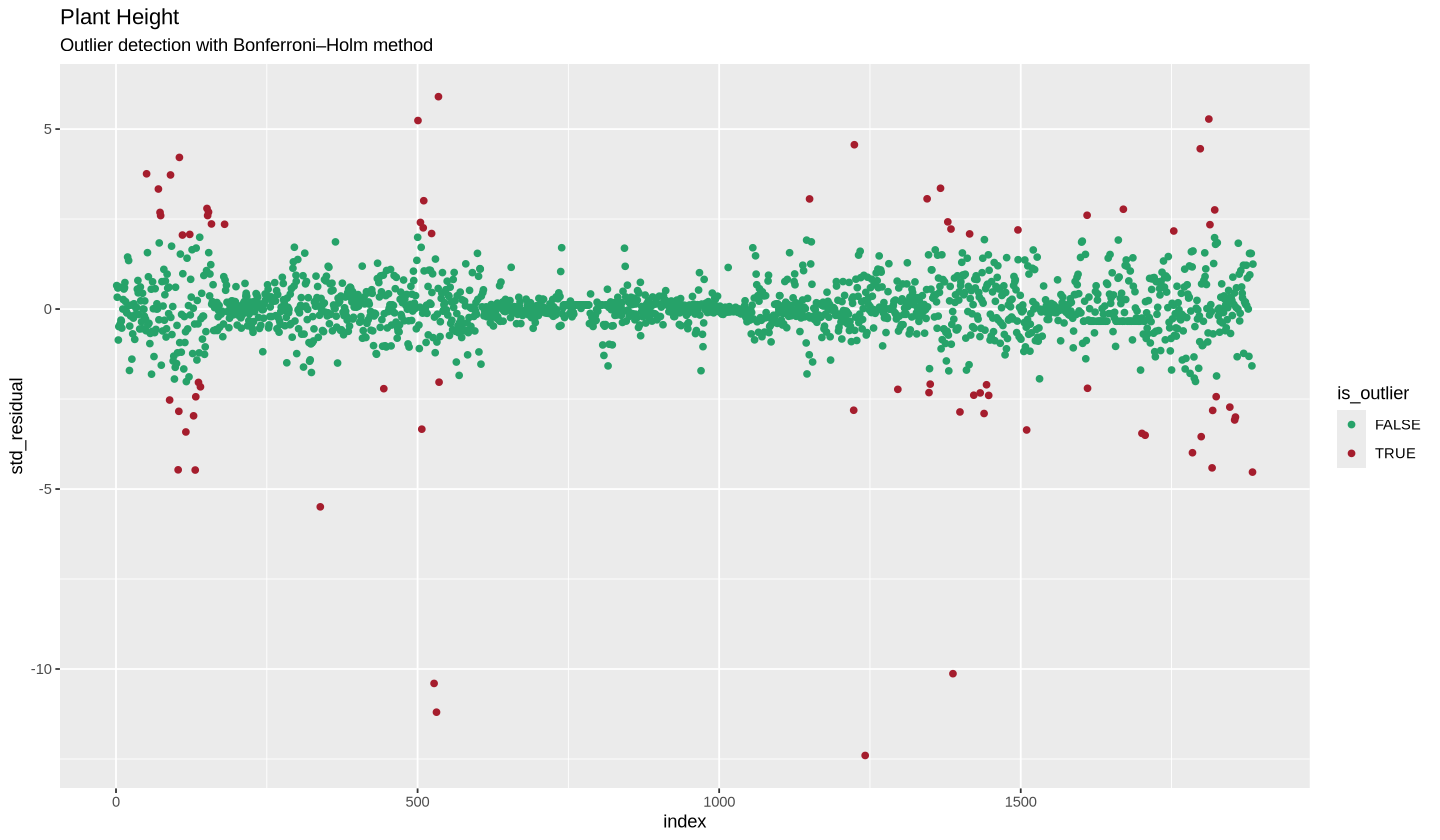

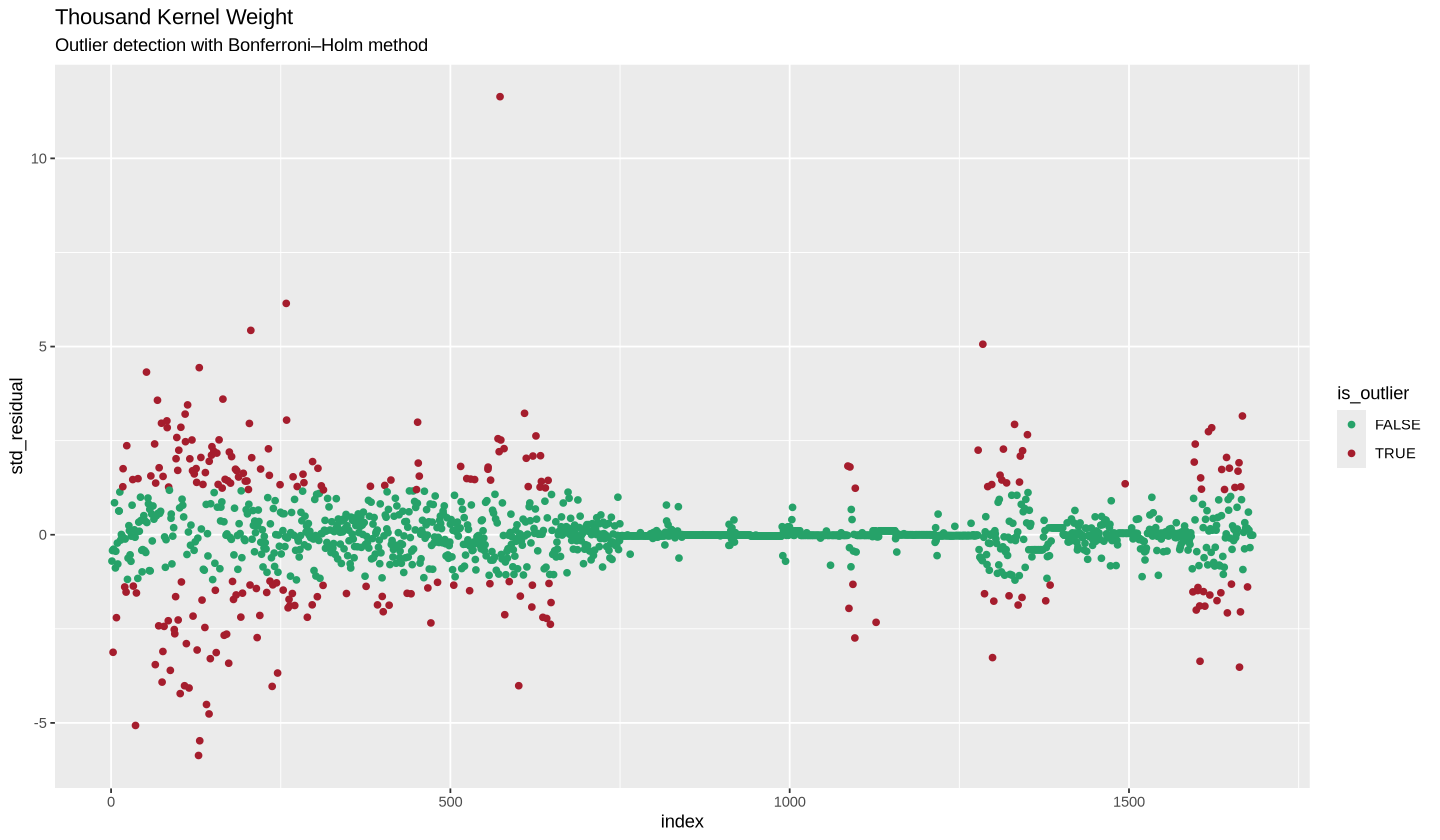

In [28]:
result_BH_WW_HT <- make_BH_multtest(asreml_res_WW_HT)
result_BH_WW_PH <- make_BH_multtest(asreml_res_WW_PH)
result_BH_WW_TKW <- make_BH_multtest(asreml_res_WW_TKW)

21 outlier value(s) detected for trait Plant Height 
18 outlier value(s) detected for trait Thousand Kernel Weight 


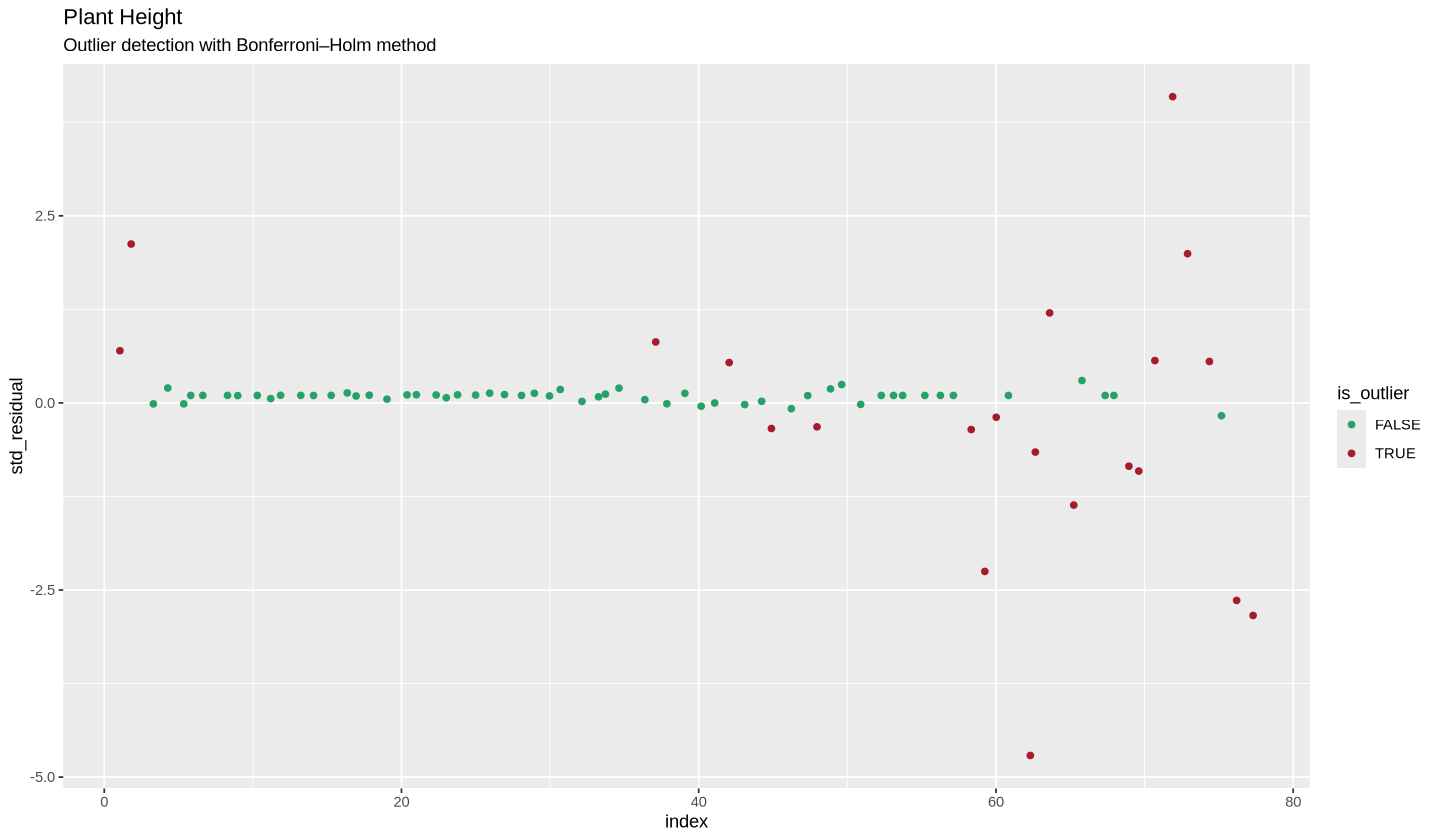

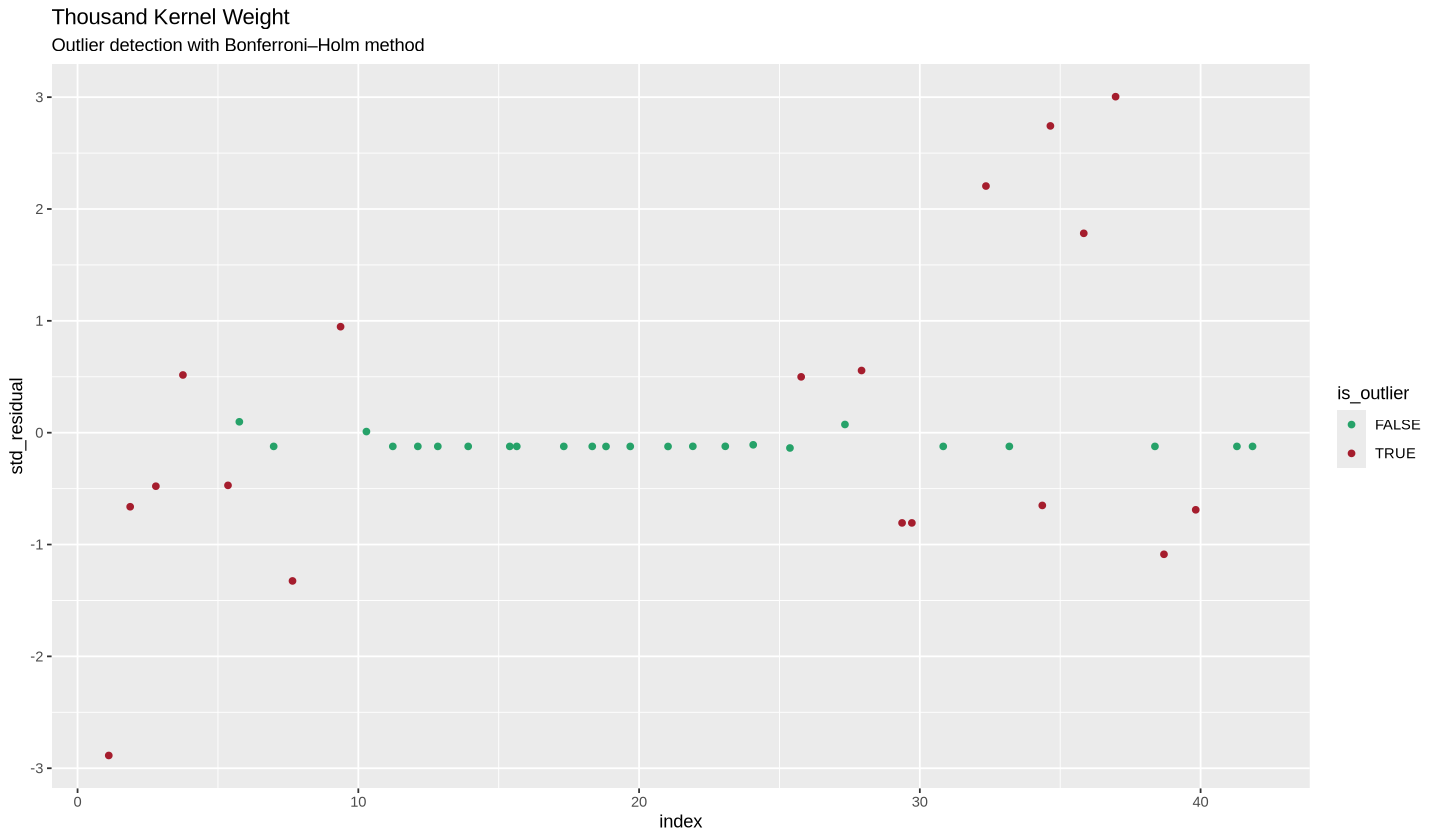

In [29]:
#result_BH_SW_HT <- make_BH_multtest(asreml_res_SW_HT)
result_BH_SW_PH <- make_BH_multtest(asreml_res_SW_PH)
result_BH_SW_TKW <- make_BH_multtest(asreml_res_SW_TKW)

In [30]:
data_corrected_WW_HT_II <- data_corrected_WW_HT_I |> correct_II(result_BH_WW_HT)
data_corrected_WW_PH_II <- data_corrected_WW_PH_I |> correct_II(result_BH_WW_PH)
data_corrected_WW_TKW_II <- data_corrected_WW_TKW_I |> correct_II(result_BH_WW_TKW)

In [31]:
#data_corrected_SW_HT_II <- data_corrected_SW_HT_I |> correct_II(result_BH_SW_HT)
data_corrected_SW_PH_II <- data_corrected_SW_PH_I |> correct_II(result_BH_SW_PH)
data_corrected_SW_TKW_II <- data_corrected_SW_TKW_I |> correct_II(result_BH_SW_TKW)

## Calculate heritability

In [32]:
asreml_res_h_WW_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_WW_HT_II)

Warning message in asreml(days_to_heading ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [33]:
asreml_res_h_WW_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_WW_PH_II)

Warning message in asreml(plant_height ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”
Warning message in asreml(plant_height ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [34]:
asreml_res_h_WW_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_WW_TKW_II)

Warning message in asreml(thousand_kernel_weight ~ 1, random = ~accenumb + campaign, :
“Warning : Log-likelihood decreased to -2100.01; trying with reduced updates 0.362140”
Warning message in asreml(thousand_kernel_weight ~ 1, random = ~accenumb + campaign, :
“Log-likelihood not converged”


In [35]:
# asreml_res_h_SW_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
#                    na.action = na.method(x="omit", y="omit"), 
#                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_SW_HT_II)

In [36]:
asreml_res_h_SW_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_SW_PH_II)

In [37]:
# asreml_res_h_SW_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
#                     na.action = na.method(x="omit", y="omit"),
#                     residual = ~dsum( ~id(units) | campaign), data = data_corrected_SW_TKW_II)
# # Error: Singularities in the average information matrix.

In [38]:
quality_WW_HT <- get_quality(data_sub_WW_HT, asreml_res_h_WW_HT)
quality_WW_PH <- get_quality(data_sub_WW_PH, asreml_res_h_WW_PH)
quality_WW_TKW <- get_quality(data_sub_WW_TKW, asreml_res_h_WW_TKW)
quality_WW_all <- bind_rows(quality_WW_HT, quality_WW_PH, quality_WW_TKW) |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_WW_all,"NPPC_winter_wheat_data_quality.csv")

days_to_heading heritability: 76.6 %
plant_height heritability: 93.6 %
thousand_kernel_weight heritability: 94.7 %


In [39]:
#quality_SW_HT <- get_quality(data_sub_SW_HT, asreml_res_h_SW_HT)
quality_SW_PH <- get_quality(data_sub_SW_PH, asreml_res_h_SW_PH)
#quality_SW_TKW <- get_quality(data_sub_SW_TKW, asreml_res_h_SW_TKW)
#quality_SW_all <- bind_rows(quality_SW_HT, quality_SW_PH, quality_SW_TKW) |> mutate(across(-1, \(x) round(x, 3)))
#write_csv(quality_SW_all,"NPPC_spring_wheat_data_quality.csv")

plant_height heritability: 99.8 %


## Run linear mixed model with outlier corrected data

In [40]:
asreml_data_WW_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_WW_HT_II)

In [41]:
asreml_data_WW_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_WW_PH_II)

Warning message in asreml(plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”
Warning message in asreml(plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [42]:
# asreml_data_WW_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
#                           na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
#                           data = data_corrected_WW_TKW_II)
# # Error: The estimation was aborted; too many exceptions.

In [43]:
# asreml_data_SW_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
#                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
#                          data = data_corrected_SW_HT_II)

In [44]:
asreml_data_SW_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_SW_PH_II)

Warning message in asreml(plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration”


In [45]:
# asreml_data_SW_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
#                           na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
#                           data = data_corrected_SW_TKW_II)
# # Error: Singularities in the average information matrix.

## Extract BLUEs and create output file

In [46]:
BLUEs_WW_HT <- get_BLUEs(asreml_data_WW_HT)
BLUEs_WW_PH <- get_BLUEs(asreml_data_WW_PH)
#BLUEs_WW_TKW <- get_BLUEs(asreml_data_WW_TKW)

BLUE_WW_all <- genotypes_w |> 
                        left_join(BLUEs_WW_HT, by="genotype") |> 
                        left_join(BLUEs_WW_PH, by="genotype") |> 
                        #left_join(BLUEs_WW_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_WW_all,"NPPC_winter_wheat_BLUE_values.csv")
summary(BLUE_WW_all)

   genotype         days_to_heading_BLUE plant_height_BLUE
 Length:4893        Min.   :210.1        Min.   : 57.02   
 Class :character   1st Qu.:220.9        1st Qu.: 83.67   
 Mode  :character   Median :223.5        Median : 92.25   
                    Mean   :223.7        Mean   : 94.35   
                    3rd Qu.:226.9        3rd Qu.:102.19   
                    Max.   :239.0        Max.   :150.99   
                    NA's   :4600         NA's   :4151     

In [47]:
#BLUEs_SW_HT <- get_BLUEs(asreml_data_SW_HT)
BLUEs_SW_PH <- get_BLUEs(asreml_data_SW_PH)
#BLUEs_SW_TKW <- get_BLUEs(asreml_data_SW_TKW)


BLUE_SW_all <- genotypes_s |> 
                        #left_join(BLUEs_SW_HT, by="genotype") |> 
                        left_join(BLUEs_SW_PH, by="genotype") |> 
                        #left_join(BLUEs_SW_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_SW_all,"NPPC_spring_wheat_BLUE_values.csv")
summary(BLUE_SW_all)

   genotype         plant_height_BLUE
 Length:891         Min.   : 79.04   
 Class :character   1st Qu.: 93.92   
 Mode  :character   Median :109.77   
                    Mean   :108.44   
                    3rd Qu.:121.86   
                    Max.   :145.72   
                    NA's   :875      

In [48]:
library(rmarkdown)
convert_ipynb("NPPC_historic_wheat_data_analysis.ipynb")

In [49]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Fedora Linux 40.20240430.0 (Silverblue)

Matrix products: default
BLAS/LAPACK: /var/home/erwan/.conda/envs/R/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.26      asreml_4.2.0.267    Matrix_1.6-5       
 [4] multtest_2.58.0     Biobase_2.62.0      BiocGenerics_0.48.1
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.4         purrr_1.0.2         readr_2.1.5        
[13] tid